# Services shortage

This example provides a pipeline to assess territory's shortage in **services**. 

P.S: It is considered that the `blocks` are already aggregated with services and the population.

In [132]:
import geopandas as gpd

blocks = gpd.read_parquet('./../data/blocks.parquet')

In [133]:
import pandas as pd

acc_mx = pd.read_pickle('./../data/accessibility_matrix.pickle')

The selected territory is an example. It is not considered as to be redeveloped or something, just what I could fetch fast from the OSM.

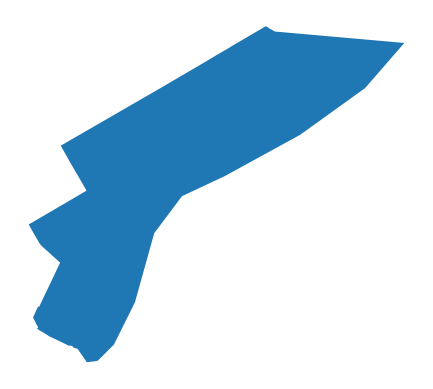

In [134]:
import osmnx as ox

project = ox.features_from_place('Российская Федерация, г. Санкт-Петербург', tags={'name': 'округ № 7'})
project.plot().set_axis_off()

Now we select project blocks

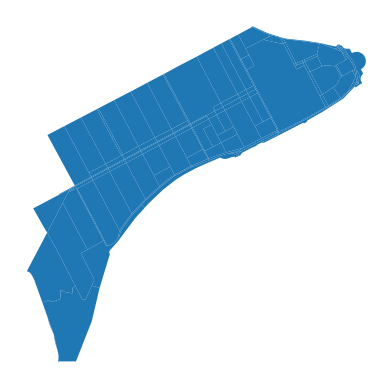

In [135]:
project_blocks = blocks[blocks.within(project.to_crs(blocks.crs).unary_union)].copy()
project_blocks.plot().set_axis_off()

## Actual code

Two cases will be considered:

- Assess the shortage for the selected territory as is.

- The selected territory is redeveloped from the ground up.

In [136]:
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

In [162]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import service_types_config
from blocksnet.analysis.provision import competitive_provision
from blocksnet.relations.accessibility import get_accessibility_context

def assess_shortage(blocks : gpd.GeoDataFrame, project_blocks : gpd.GeoDataFrame, acc_mx : pd.DataFrame, service_type : str, ground_up : bool = False):
    _, demand, accessibility = service_types_config[service_type].values()
    provision_blocks = blocks[['population', f'capacity_{service_type}']].rename(columns={f'capacity_{service_type}': 'capacity'}).copy()
    if ground_up:
        provision_blocks.loc[project_blocks.index] = 0

    provision, _ = competitive_provision(provision_blocks, acc_mx, demand, accessibility)  
    
    context_mx = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=True)
    context_provision_df = provision.loc[context_mx.index]
    shortage = context_provision_df['demand_left'].sum()

    return shortage

As is

In [158]:
from tqdm import tqdm

shortages_as_is = {}

for service_type in tqdm(service_types_config.service_types.index):
    column = f'capacity_{service_type}'
    if column in blocks.columns:
        shortage = assess_shortage(blocks, project_blocks, acc_mx, service_type, False)
        shortages_as_is[service_type] = shortage

100%|██████████| 78/78 [13:38<00:00, 10.49s/it]


In [159]:
shortages_as_is

{'school': 329,
 'kindergarten': 2322,
 'hospital': 0,
 'polyclinic': 314,
 'pitch': 0,
 'swimming_pool': 4842,
 'stadium': 12658,
 'theatre': 83,
 'museum': 0,
 'cinema': 273,
 'mall': 0,
 'convenience': 1772,
 'supermarket': 1330,
 'cemetery': 312702,
 'religion': 33,
 'market': 1107893,
 'bowling_alley': 37174,
 'university': 0,
 'playground': 30,
 'pharmacy': 0,
 'fuel': 0,
 'beach': 262447,
 'train_building': 140974,
 'bank': 0,
 'lawyer': 19704,
 'cafe': 0,
 'subway_entrance': 139369,
 'multifunctional_center': 136925,
 'hairdresser': 1,
 'restaurant': 1028,
 'bar': 60,
 'park': 0,
 'government': 0,
 'recruitment': 21108,
 'hotel': 0,
 'zoo': 998,
 'circus': 2139,
 'post': 122662,
 'police': 99,
 'dog_park': 18013,
 'hostel': 30288,
 'bakery': 46,
 'parking': 10905,
 'guest_house': 33033,
 'reserve': 232503,
 'sanatorium': 33033,
 'embankment': 45035,
 'brewery': 11778,
 'woodworking_plant': 8707,
 'oil_refinery': 5164,
 'plant_of_building_materials': 46469,
 'wastewater_plant': 

Ground up

In [163]:
shortages_g_up = {}

for service_type in tqdm(service_types_config.service_types.index):
    column = f'capacity_{service_type}'
    if column in blocks.columns:
        shortage = assess_shortage(blocks, project_blocks, acc_mx, service_type, True)
        shortages_g_up[service_type] = shortage

100%|██████████| 78/78 [12:40<00:00,  9.75s/it]


In [164]:
shortages_g_up

{'school': 391,
 'kindergarten': 755,
 'hospital': 0,
 'polyclinic': 261,
 'pitch': 0,
 'swimming_pool': 5205,
 'stadium': 12222,
 'theatre': 83,
 'museum': 0,
 'cinema': 268,
 'mall': 0,
 'convenience': 70,
 'supermarket': 111,
 'cemetery': 308537,
 'religion': 33,
 'market': 1075035,
 'bowling_alley': 36784,
 'university': 0,
 'playground': 1,
 'pharmacy': 0,
 'fuel': 0,
 'beach': 259668,
 'train_building': 139539,
 'bank': 0,
 'lawyer': 19096,
 'cafe': 0,
 'subway_entrance': 121665,
 'multifunctional_center': 119935,
 'hairdresser': 0,
 'restaurant': 1332,
 'bar': 138,
 'park': 0,
 'government': 0,
 'recruitment': 20458,
 'hotel': 0,
 'zoo': 912,
 'circus': 2095,
 'post': 82173,
 'police': 78,
 'dog_park': 15711,
 'hostel': 29939,
 'bakery': 6,
 'parking': 4352,
 'guest_house': 32597,
 'reserve': 230332,
 'sanatorium': 32597,
 'embankment': 43653,
 'brewery': 11561,
 'woodworking_plant': 8621,
 'oil_refinery': 5120,
 'plant_of_building_materials': 46033,
 'wastewater_plant': 4603284

In [176]:
shortages_df = pd.DataFrame.from_dict(shortages_g_up, orient='index')
shortages_df.columns = ['shortage']
shortages_df[shortages_df['shortage']>0].sort_values('shortage', ascending=False)

,shortage
water_works,4605078
wastewater_plant,4603284
substation,1476971
market,1075035
bus_station,691012
cemetery,308537
beach,259668
reserve,230332
train_building,139539
subway_entrance,121665
